In [47]:
# import packages and own functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
import os

from Classifier.load_data import load_training_data
from Classifier.plot_data import plot_labelled_wave

from catch22 import catch22_all
import catch22

from scipy.io import wavfile

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

In [38]:
# load in training data

waves, labels, samprate = load_training_data(path = "C:/Users/souls/Documents/Aqua10/Datasets/Good Data - Sandeep no errors/",
                       scale_factor= 512/(2**13 - 1),
                       blacklist = ["blink", "different", "fast", "slow", "eyebrow"])

dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'left-right-middle-marina', 'left-right-middle-marina2', 'left-right-middle-marina3', 'left-right-middle-sandeep', 'right-middle']) dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'left-right-middle-marina', 'left-right-middle-marina2', 'left-right-middle-marina3', 'left-right-middle-sandeep', 'right-middle'])


C:\Users\souls\Documents\Aqua10\Classifier\load_data.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [51]:
# extract events from training data

time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

before_buffer = 0.5
after_buffer = 1
    
events = [] # list of events in terms of slice of wav_array
event_labels = [] # list of labels

for key in labels:
    wave = waves[key]
    label = labels[key]
    for lab, time in zip(label.label, label.time):
        event_labels.append(lab)
        event_start = int((time - before_buffer) * samprate) # in terms of sampling rate
        event_end = int((time + after_buffer) * samprate) # in terms of sampling rate

        events.append(wave[event_start:event_end])

['L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'L', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'R', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'R', 'R', 'L', 'L', 'L', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'L', 'R', 'R', 'R', 'L', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'L', 'R', 'R', 'L', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'R', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'R', 'L', 'L', 'L', 'R', 'R', 'R', 'R', 'L', 'L', 'R', 'L', 'L', 'R',

In [50]:
# compute catch22 features and convert to dataframe

features = []
for event in events:
    event_ds = event[0::10] # downsample by a rate of 10
    feature = catch22_all(event_ds)
    features.append(feature['values'])

features_df = pd.DataFrame(features)
features_df.columns = feature['names']

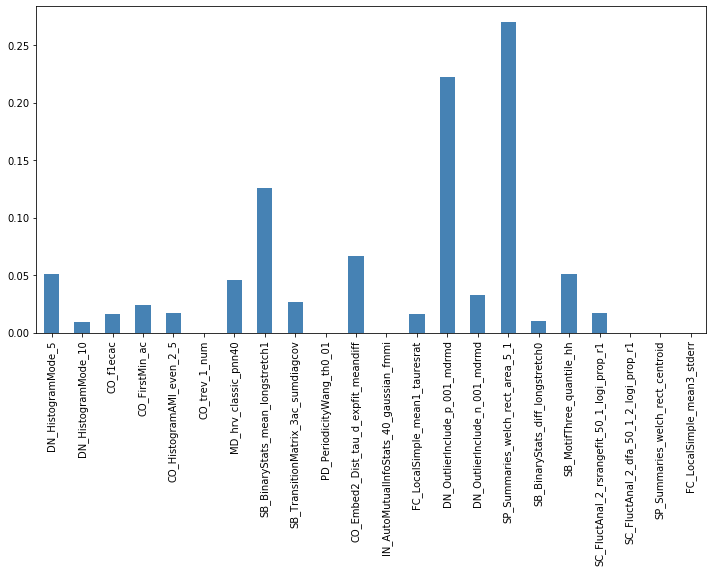

In [53]:
# print(features_df)

clf = DecisionTreeClassifier()
clf.fit(features_df, event_labels)

pd.Series(clf.feature_importances_, index=features_df.columns).plot.bar(color='steelblue', figsize=(12, 6))

# trans = SelectFromModel(clf, threshold='median')


In [35]:

# path = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/Eye Data/"

# path = 'C:/Users/David/Documents/DATA3888/Aqua10/Datasets/Eye Data/'

# path = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/"

# path = 'C:/Users/souls/Documents/Aqua10/Datasets/Eye Data/'

path = 'C:/Users/souls/Documents/Aqua10/Datasets/Good Data - Sandeep no errors/'

files = os.listdir(path)

# file = "left-right"

waves = {}
labels = {}

for file in files:
    
    if ("right" in file.lower() or "left" in file.lower()) and "blink" not in file.lower() and "eyebrow" not in file.lower():
        if file[-4::] == ".wav":
            samprate, wav_array = wavfile.read(path+file)
            
            # Normalise to +- 512:
            wav_array = wav_array/(2**13 - 1)*512
            wav_array = np.round(wav_array).astype(np.int)

            waves[file[:-4]] = wav_array
            
            
            
        elif file[-4::] == ".txt":
            labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)
            labels_dat.columns = ["label", "time"]
            # Change depending on whether L is coded as 1 or as 2
            labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]

            labels[file[:-4].replace(".", "")] = labels_dat

            
    
# samprate, wav_array = wavfile.read(path+file+".wav")

# # Normalise to +- 512:
# wav_array = wav_array/(2**13 - 1)*512
# wav_array = np.round(wav_array).astype(np.int)

# plt.plot(wav_array)




C:\Users\souls\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


308 -407
10000
164 -208
10000
354 -223
10000
133 -104
10000
142 -198
10000
170 -181
10000
195 -203
10000
162 -105
10000
155 -115
10000
153 -155
10000
230 -139
10000
70 -65
10000
107 -192
10000
200 -181
10000


In [23]:
# Load in labels


# labels = pd.read_csv(path+file+"..txt", sep=",\t", skiprows=1)

# labels.columns = ["label", "time"]

# # Change depending on whether L is coded as 1 or as 2
# labels.label = ["L" if label == 1 else "R" for label in labels.label]

# labels



C:\Users\souls\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,label,time
0,L,2.8675
1,R,5.4405
2,R,7.7814
3,L,9.9956
4,R,12.2611
5,L,14.4050
6,L,16.6543
7,R,18.8625
8,R,20.9803
9,L,23.1502


[array([-4, -3, -3, ...,  1,  1,  1]), array([ 2,  2,  2, ..., 15, 15, 15]), array([-4, -4, -4, ...,  4,  4,  4]), array([-6, -6, -6, ..., -9, -9, -9]), array([3, 3, 3, ..., 5, 5, 5]), array([ 6,  6,  6, ..., -4, -4, -4]), array([-3, -3, -3, ..., -3, -3, -3]), array([-9, -9, -9, ..., 11, 10, 11]), array([ 2,  2,  2, ...,  0,  0, -1]), array([-1, -1, -1, ...,  0,  0,  0]), array([-3, -3, -3, ..., -9, -9, -9]), array([1, 1, 1, ..., 4, 4, 4])]


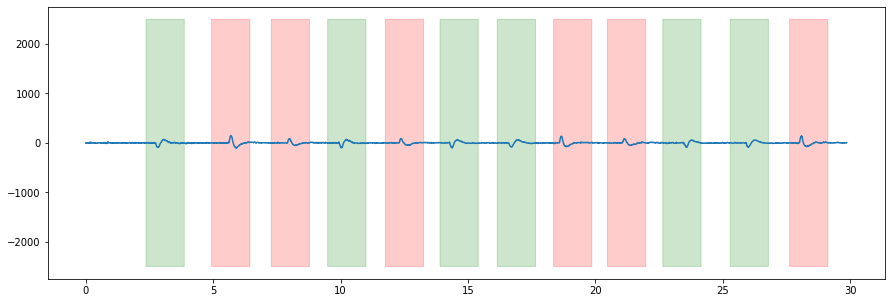

In [24]:
time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate


before_buffer = 0.5
after_buffer = 1

left_events_bool = np.array([False]*len(time_seq))
for time in labels.time[labels.label == "L"]:
    left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool
    
right_events_bool = np.array([False]*len(time_seq))
for time in labels.time[labels.label == "R"]:
    right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

events = [] # list of events in terms of slice of wav_array
for key in labels:
    for time in labels.time:
        event_start = int((time - before_buffer) * samprate) # in terms of sampling rate
        event_end = int((time+after_buffer) * samprate) # in terms of sampling rate

        events.append(wav_array[event_start:event_end])
    
print(events)
    
plt.figure(figsize=(15, 5))
    
plt.plot(time_seq, wav_array)

plt.fill_between(time_seq, 2500, -2500,
                 where = left_events_bool,
                 color = 'g',
                 alpha=0.2)

plt.fill_between(time_seq, 2500, -2500,
                 where = right_events_bool,
                 color = 'r',
                 alpha=0.2)




# plt.fill_betweenx(ys, start_times, end_times,
#                  facecolor="orange", # The fill color
#                  color='blue',       # The outline color
#                  alpha=0.2)          # Transparency of the fill



In [25]:
# # Livestreaming data


# # use this to find ports
# import serial
# from serial.tools import list_ports


# ports = list_ports.comports()
# for port in ports:
#     print(port)
    

    
# samprate = 20000
# inputBufferSize = 10000

# # Read example data
# baudrate = 230400
# cport = '/dev/cu.usbmodem142301'  # set the correct port before you run it
# ser = serial.Serial(port=cport, baudrate=baudrate)   


features = []
for event in events:
    event_ds = event[0::10] # downsample by a rate of 10
    feature = catch22_all(event_ds)
    features.append(feature['values'])

features_df = pd.DataFrame(features)



In [34]:
print(features_df)
# Testing catch22 feature implementation

# keyFeature = []

# for event in events:
#     event_ds = event[0::10] # downsample by a rate of 10
#     event_list = event_ds.tolist()
#     feature = catch22.SB_BinaryStats_mean_longstretch1(event_list)
#     keyFeature.append(feature)

# print(keyFeature)

    DN_HistogramMode_5  DN_HistogramMode_10  CO_f1ecac  CO_FirstMin_ac  \
0            -0.322609            -0.075541        104             253   
1             0.504818             0.230935         89             233   
2            -0.377711            -0.115323         94             249   
3            -0.532785            -0.263269         88             265   
4            -0.210663             0.047023         97             302   
5            -0.510917            -0.239542         90             243   
6            -0.315201            -0.072385        114             290   
7            -0.306882            -0.039486         84             270   
8            -0.331204            -0.079201         97             275   
9             0.462625             0.198102         92             226   
10           -0.553353            -0.304571        110             285   
11           -0.254550             0.013467         83             249   

    CO_HistogramAMI_even_2_5  CO_trev

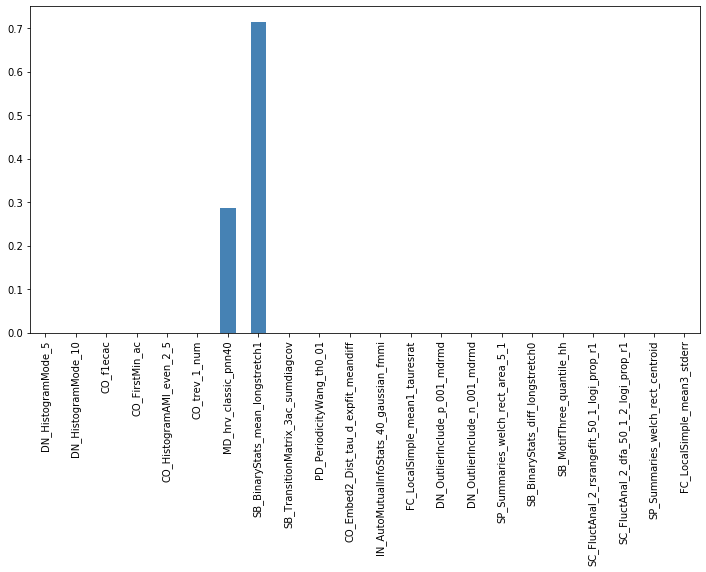

In [33]:
# feature selection using decision trees

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

features_df.columns = feature['names']

y = labels.label

clf = DecisionTreeClassifier()
clf.fit(features_df, y)

pd.Series(clf.feature_importances_, index=features_df.columns).plot.bar(color='steelblue', figsize=(12, 6))

trans = SelectFromModel(clf, threshold='median')

# running this a few times, SB_BinaryStats_mean_longstretch1 is the most important while sometimes,
# another feature helps support for a max of 2 features
# results slightly differ with normalisation but are largely the same

In [ ]:
# catch22_classifier
# assume that an event has been identified and a numpy array has been given

def catch22_classifier(arr, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_list = arr_ds.tolist() # single catch22 feature won't take numpy arrays, only lists or tuples
    
    key_feature = catch22.SB_BinaryStats_mean_longstretch1(arr_list)
    
    
    
    

In [ ]:

# SINCE THE STREAMING DATA COMES IN FROM THE RIGHT TO THE LEFT ON THE PLOT, 
# THE RESULTANT PLOT IS ACTUALLY REFLECTED ABOUT THE Y AXIS


samprate = 20000

%matplotlib notebook


# Things you can change:
window_size = 1.5; # time plotted in window [s]
N_loops_over_window = 16 # implicityly defines buffer size so that its 1/<N_loops_over_window>ths of a window

# Things you shouldn't need to change:
inputBufferSize = int(window_size/N_loops_over_window * samprate)

total_time = len(wav_array)/samprate; # time in seconds [[1 s = 20000 buffer size]]
N_loops =(total_time*samprate)//inputBufferSize  # len(wav_array)//inputBufferSize 
T_acquire = inputBufferSize/samprate    # length of time that data is acquired for 
N_loops_over_window = window_size/T_acquire    # total number of loops to cover desire time window



print("total_time", total_time)
print("window_size", window_size)
print("N_loops", N_loops)
print("T_acquire", T_acquire)
print("N_loops_over_window", N_loops_over_window)




# Initialise plot
min_y = -2500 #np.min(wav_array)
max_y = 2500 #np.max(wav_array)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()



for k in range(0,int(N_loops)):
    
    # Simulate stream
    data_temp = read_arduinbro(wav_array, inputBufferSize, k)

    # Stream
#     data = read_arduino(ser,inputBufferSize)
#     data_temp = process_data(data)
    

    if k < N_loops_over_window:
        if k==0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp,data_plot)
            
        continue
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
        
    
    
    ## PLOT ###
    
    
    t = (min(k+1,N_loops_over_window))*inputBufferSize/samprate*np.linspace(0,1,(data_plot).size)
    ax1.clear()
    ax1.set_xlim(0, window_size)
    ax1.set_ylim(min_y, max_y)
    plt.xlabel('time [s]')
    ax1.plot(t,data_plot)
    fig.canvas.draw()    
    plt.show()


